In [2]:
import json, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Sequence, Optional

In [3]:
import os
os.chdir('../..')
print("Working directory:", os.getcwd())

Working directory: c:\0. Studia\Magisterka\Praca magisterska\Experiments


In [4]:
MOD_PATTERNS = [
    r"noise_snr\\d+",
    r"resample\\d+k",
    r"reverb_[^/\\]+",
    r"mp3_\\d+",
    r"base",
    r"minus\\d+",
]
MOD_REGEX = re.compile("(" + "|".join(MOD_PATTERNS) + ")", re.IGNORECASE)

In [ ]:
def extract_mod_label(path: str) -> str:
    p = Path(path)
    parts = list(p.parts)
    if 'FakeRealMusicOriginal' in parts and 'Normalized' not in "".join(parts):
        return 'baseline'
    if 'FakeRealMusicOriginalNormalized' in parts:
        try:
            idx = parts.index('FakeRealMusicOriginalNormalized')
            mod_folder = parts[idx+1]
            mod_type = parts[idx+2]
            num = mod_folder.replace('minus', '')
            return f"{mod_type}_{num}"
        except Exception:
            pass
    return p.stem

def load_runs_with_mod(files: Sequence[str], threshold: float = 0.5) -> pd.DataFrame:
    rows = []
    for p in files:
        with open(p, 'r', encoding='utf-8') as f:
            data = json.load(f)
        run_label = extract_mod_label(p)
        for model_name, audio_items in data.items():
            for audio_stem, rec in audio_items.items():
                pred_data = rec.get('preedictions', {})
                model_prob = pred_data.get('model_prediction')
                if model_prob is None:
                    continue
                rows.append({
                    'run_path': p,
                    'run': run_label,
                    'source': model_name,
                    'idx': str(audio_stem),
                    'score_fake_prob': model_prob,
                })
    df = pd.DataFrame(rows)
    df['pred_by_threshold'] = (df['score_fake_prob'] >= threshold).map({True:'Fake', False:'Real'})
    
    def try_num(s):
        try:
            return int(s)
        except Exception:
            return s
    df['idx_sort'] = df['idx'].map(try_num)
    return df

In [ ]:
PALETTE = sns.color_palette('tab10', 10)

def plot_model_trajectories_by_mod(df: pd.DataFrame, source: str,
                                   audio_idx_subset: Optional[Sequence[str]] = None,
                                   annotate_decision: bool = False,
                                   figsize=(12,5)):
    data = df[df['source']==source].copy()
    if data.empty:
        raise ValueError(f"No data for source: {source}")   
    if audio_idx_subset is not None:
        audio_idx_subset = [str(x) for x in audio_idx_subset]
        data = data[data['idx'].isin(audio_idx_subset)]

    data = data.sort_values(['idx_sort','run'])

    runs = sorted(data['run'].unique(), key=lambda s: s.lower())
    idxs = sorted(data['idx'].unique(), key=lambda s: (str(s).isdigit(), int(s) if str(s).isdigit() else s))
    idx_pos = {idx:i for i, idx in enumerate(idxs)}

    plt.figure(figsize=figsize)
    markers = ['o','s','D','^','v','P','X','*','h','8']

    for r_i, run in enumerate(runs):
        g = data[data['run']==run].sort_values('idx_sort')
        x = [idx_pos[v] + (r_i - (len(runs)-1)/2)*0.14 for v in g['idx']]
        color = PALETTE[r_i % len(PALETTE)]
        plt.plot(x, g['score_fake_prob'],
                 marker=markers[r_i % len(markers)],
                 linewidth=1.8, markersize=6,
                 alpha=0.95, label=run, color=color)
        if annotate_decision:
            for xi, y in zip(x, g['score_fake_prob']):
                lab = 'F' if y>=0.5 else 'R'
                plt.text(xi, y+0.025, lab, ha='center', va='bottom', fontsize=8, color='#111827')

    plt.axhline(0.5, color='red', linestyle='--', linewidth=1.2, label='Próg 0.5')
    short_labels = [str(i)[:10]+"..." if len(str(i)) > 10 else str(i) for i in idxs]
    plt.xticks([idx_pos[i] for i in idxs], range(len(idxs)))

    plt.title(f"{source}: P(Fake) vs audio index (colour = modification)")
    plt.xlabel("Audio index (0,1,2,...")
    plt.ylabel("P(Fake)")
    plt.ylim(-0.05, 1.05)
    plt.legend(title='Modification (run)', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_with_right_box(df, source, idxs, idx_pos, PALETTE, runs, short_labels, annotate_decision=False, figsize=(12,5)):
    fig, ax = plt.subplots(figsize=(16,6))
    markers = ['o','s','D','^','v','P','X','*','h','8']
    for r_i, run in enumerate(runs):
        g = df[(df['run']==run) & (df['source']==source)].sort_values('idx_sort')
        x = [idx_pos[v] + (r_i - (len(runs)-1)/2)*0.14 for v in g['idx']]
        color = PALETTE[r_i % len(PALETTE)]
        ax.plot(x, g['score_fake_prob'], marker=markers[r_i % len(markers)],
                 linewidth=1.8, markersize=6,
                 alpha=0.95, label=run, color=color)
        if annotate_decision:
            for xi, y in zip(x, g['score_fake_prob']):
                lab = 'F' if y>=0.5 else 'R'
                ax.text(xi, y+0.025, lab, ha='center', va='bottom', fontsize=8, color='#111827')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=1.2, label='Próg 0.5')
    ax.set_xticks([idx_pos[i] for i in idxs])
    ax.set_xticklabels(range(len(idxs)))
    ax.set_title(f"{source}: P(Fake) vs audio index (colour = modification)")
    ax.set_xlabel("Audio index (0,1,2,...)")
    ax.set_ylabel("P(Fake)")
    ax.set_ylim(-0.05, 1.05)
    ax.legend(title='Modification (run)', bbox_to_anchor=(1.02, 0.5), loc='center left')
    fig.tight_layout(rect=[0, 0, 0.8, 1])
    legend_text = "\n".join([f"{idx}: {label}" for idx, label in enumerate(short_labels)])
    fig.text(0.8, 0.5, "Audio index map:\n" + legend_text, fontsize=10, va='center', ha='left', bbox=dict(facecolor='#f9f9f9', edgecolor='#dedede', boxstyle='round,pad=0.6'))
    plt.show()


In [ ]:
import plotly.graph_objs as go

def plot_plotly_interactive(df, source, idxs, idx_pos, runs, short_labels, offset=0.12):
    fig = go.Figure()
    N = len(runs)
    for r_i, run in enumerate(runs):
        g = df[(df['run']==run) & (df['source']==source)].sort_values('idx_sort')
        xbase = [idx_pos[v] for v in g['idx']]
        x = [xi + (r_i - (N-1)/2)*offset for xi in xbase]
        y = g['score_fake_prob']
        idx_map = [f"{int(round(xi))}: {short_labels[int(round(xi))]}" for xi in xbase]
        fig.add_trace(go.Scatter(
            x=x, y=y, mode='lines+markers',
            name=run,
            text=idx_map,
            hoverinfo='text+y'
        ))
    fig.add_hline(y=0.5, line_color='red', line_dash="dash", annotation_text='Próg 0.5', annotation_position='top right')
    fig.update_layout(
        title=f'{source}: P(Fake) vs audio index (colour = modification)',
        xaxis_title='Audio index (0,1,2,...)',
        yaxis_title='P(Fake)',
        legend_title='Modification (run)',
        xaxis=dict(tickvals=list(range(len(idxs))), ticktext=list(range(len(idxs))))
    )
    fig.show()

In [9]:
input_files = [
    'results/Predictions/FakeRealMusicOriginal/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus14/base/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus14/mp3_192/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus14/noise_snr30/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus14/resample22k/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus14/reverb_room/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus23/base/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus23/mp3_192/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus23/noise_snr30/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus23/resample22k/FULL_TEST/full_track/predictions.json',
    # 'results/Predictions/FakeRealMusicOriginalNormalized/minus23/reverb_room/FULL_TEST/full_track/predictions.json',
]

df_all = load_runs_with_mod(input_files, threshold=0.5)

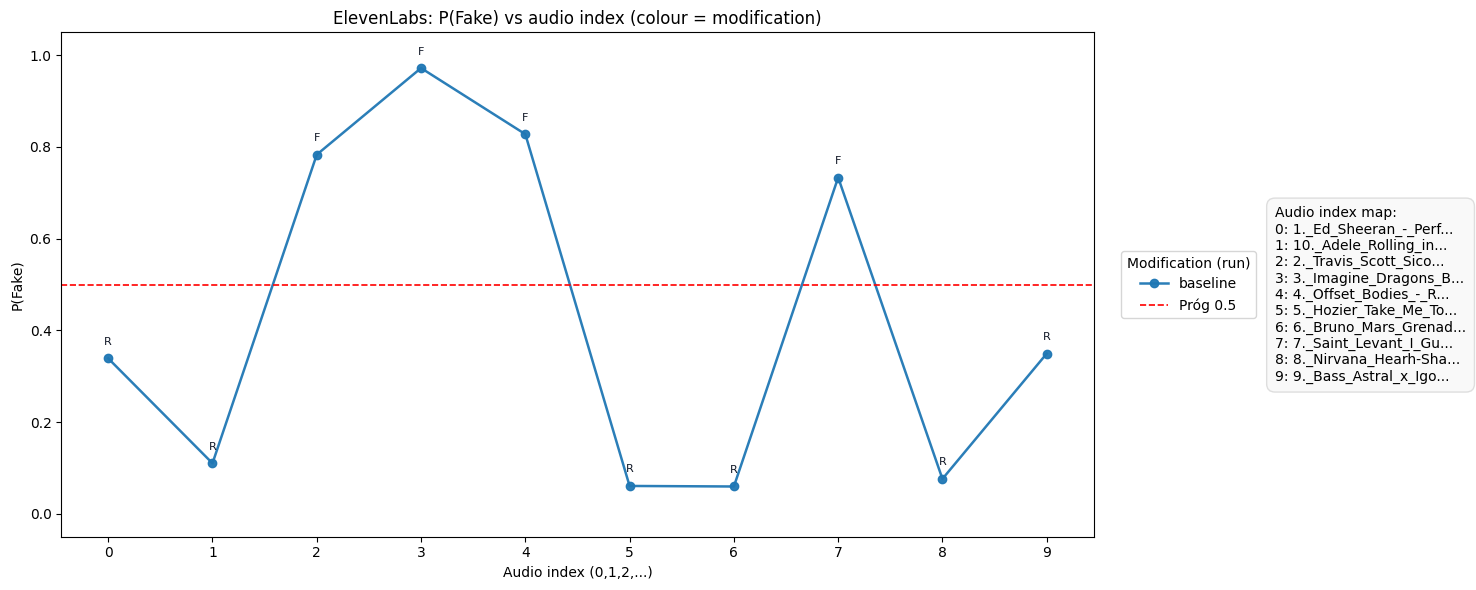

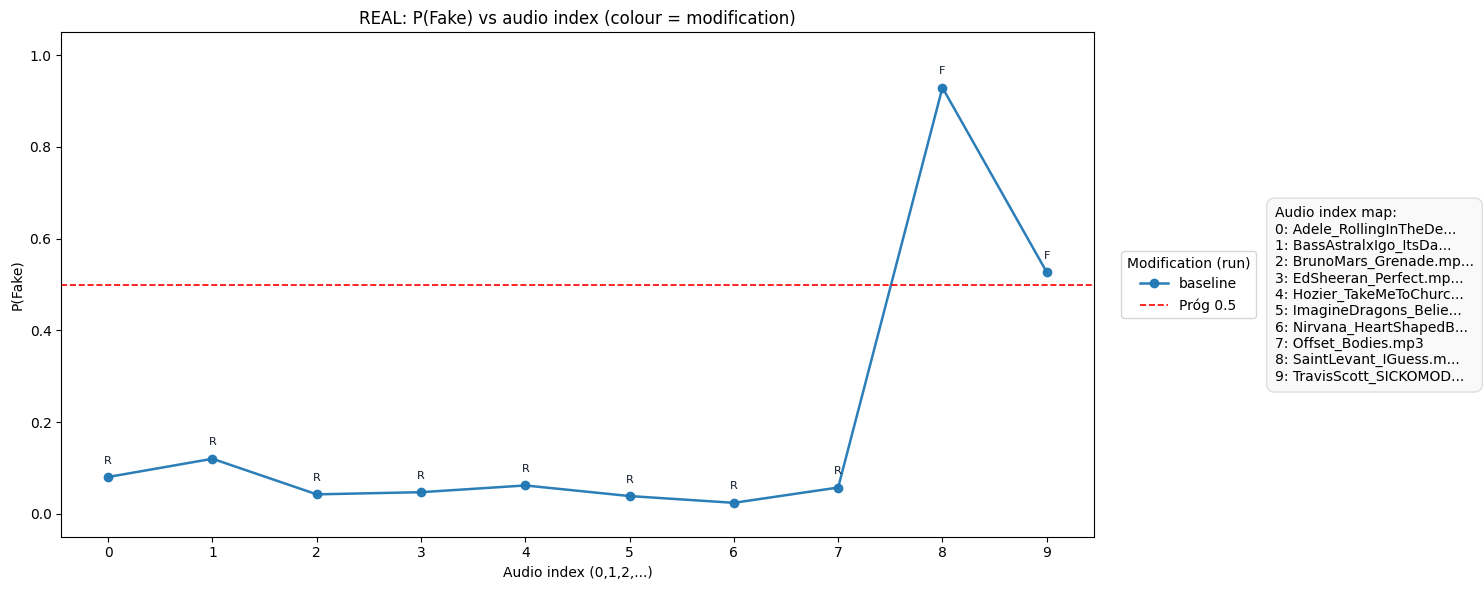

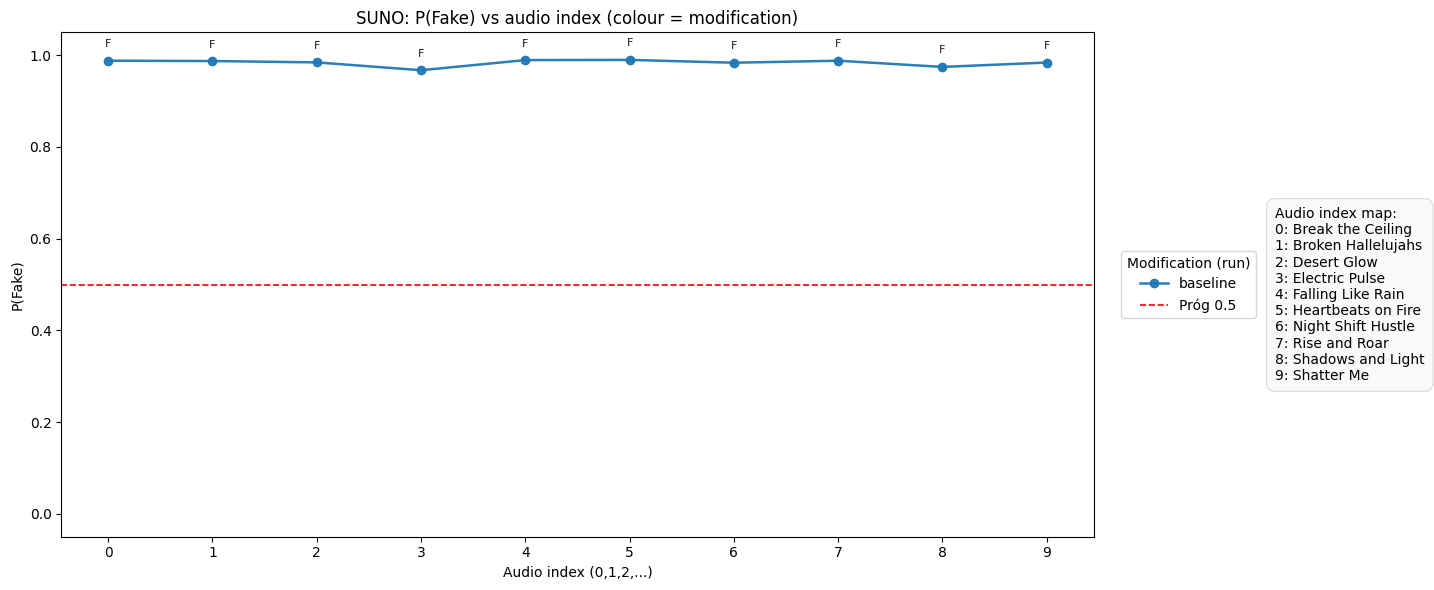

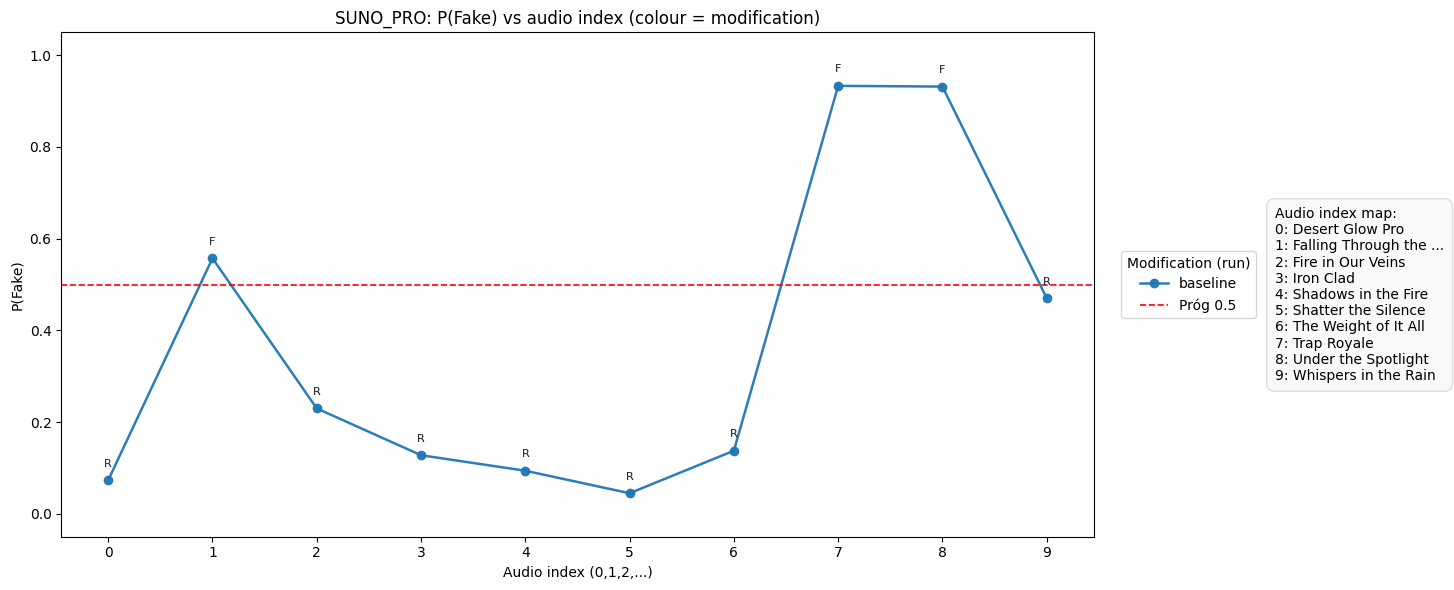

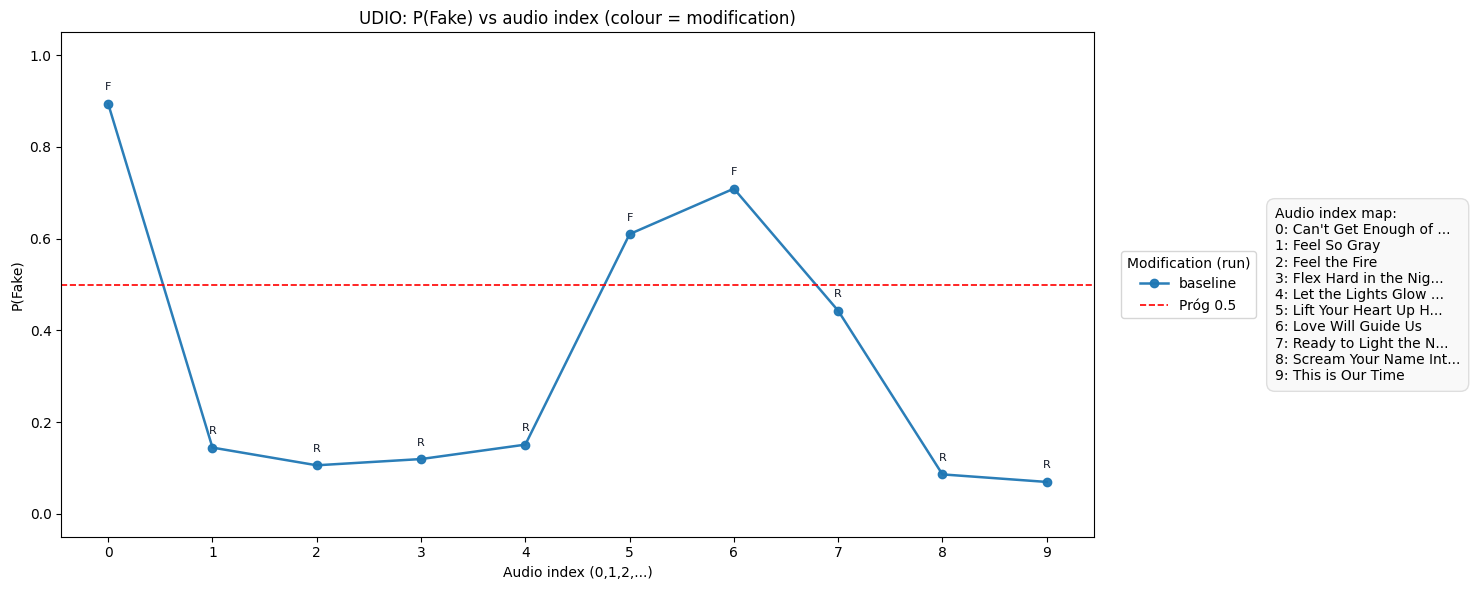

In [10]:
for source in ['ElevenLabs', 'REAL', 'SUNO', 'SUNO_PRO', 'UDIO']:
    df_sub = df_all[df_all['source'] == source]
    runs = sorted(df_sub['run'].unique(), key=lambda s: s.lower())
    idxs = sorted(df_sub['idx'].unique(), key=lambda s: (str(s).isdigit(), int(s) if str(s).isdigit() else s))
    idx_pos = {idx:i for i, idx in enumerate(idxs)}
    short_labels = [str(i)[:20]+"..." if len(str(i)) > 20 else str(i) for i in idxs]  # dostosuj według potrzeb

    plot_with_right_box(df_all, source, idxs, idx_pos, PALETTE, runs, short_labels, annotate_decision=True, figsize=(12,5))
    plot_plotly_interactive(df_all, source, idxs, idx_pos, runs, short_labels)

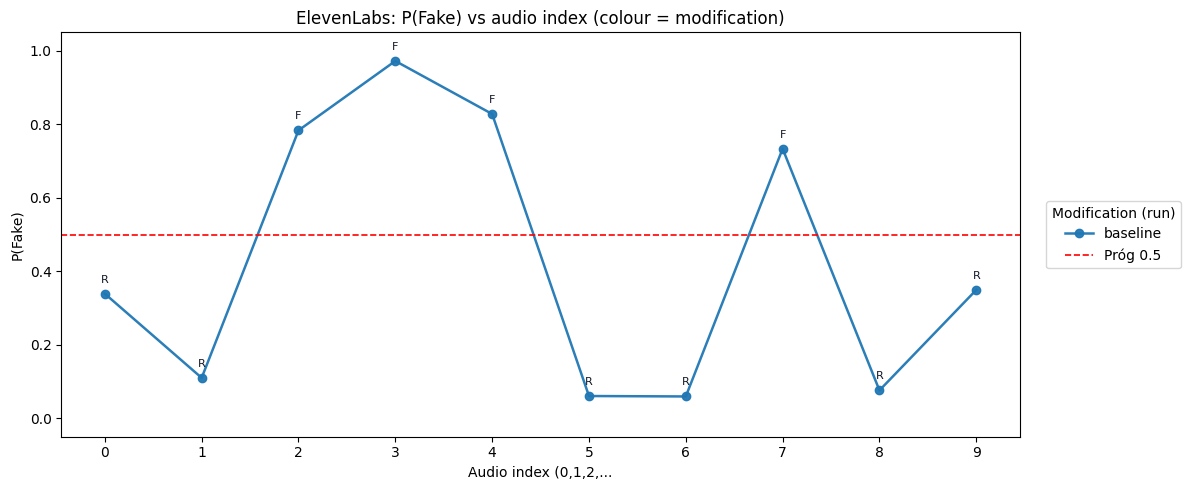

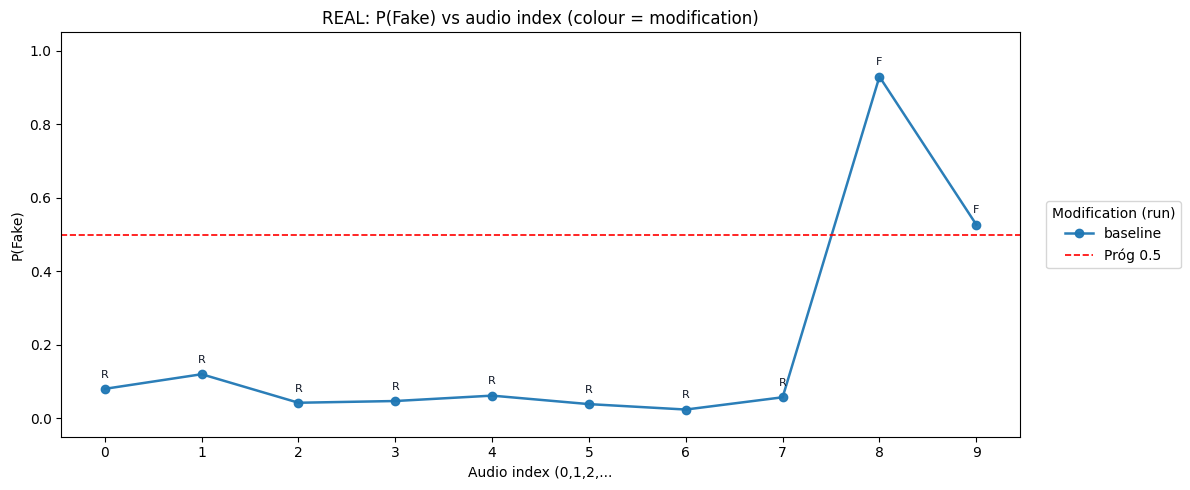

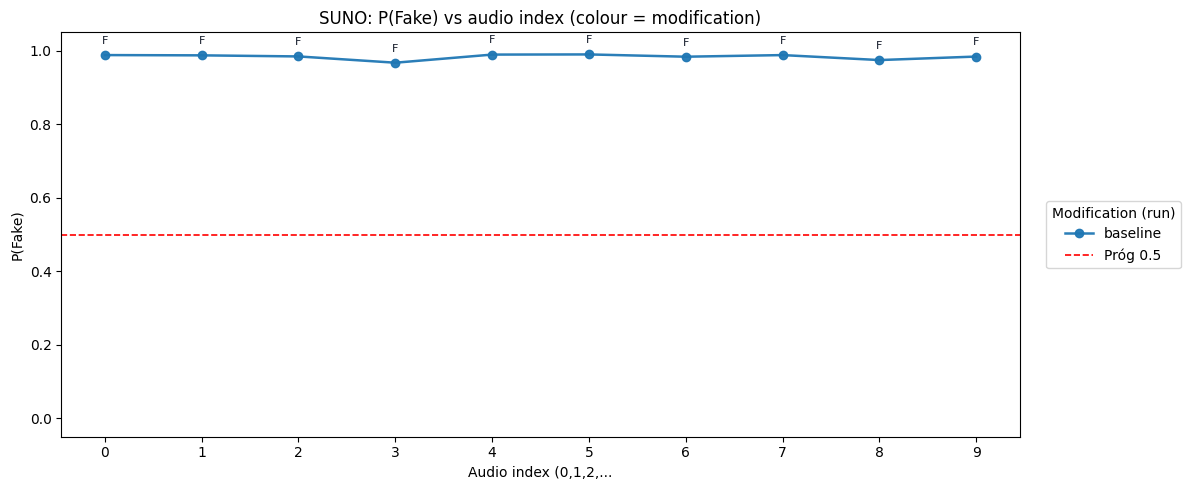

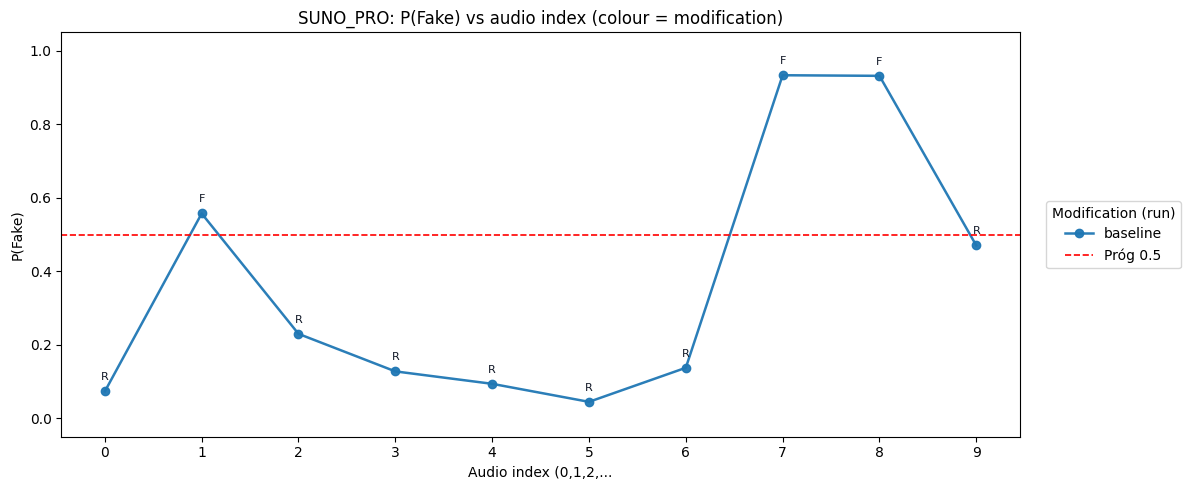

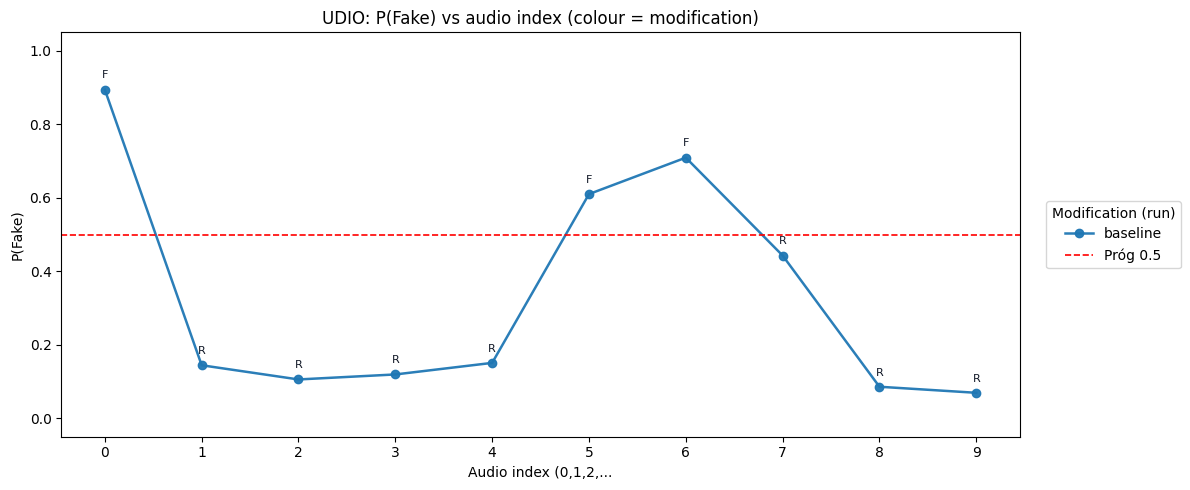

In [11]:
plot_model_trajectories_by_mod(df_all, source='ElevenLabs', annotate_decision=True)
plot_model_trajectories_by_mod(df_all, source='REAL', annotate_decision=True)
plot_model_trajectories_by_mod(df_all, source='SUNO', annotate_decision=True)
plot_model_trajectories_by_mod(df_all, source='SUNO_PRO', annotate_decision=True)
plot_model_trajectories_by_mod(df_all, source='UDIO', annotate_decision=True)